In [5]:
from textwrap import indent

from liblet import ANTLR, Tree, warn

# Symbol table 

Per tener traccia dei simboli (in questo caso le variabili) del nostro programma usiamo delle *Symbol table* che organizziamo in un *albero* per rappresentare l'inclusione dei blocchi.

In [6]:
class SymbolTable:
    
    def __init__(self, parent = None):
        self.parent = parent
        self.symbols = {}
        
    def get(self, symbol):
        try:
            return self.symbols[symbol]
        except KeyError as e:
            if self.parent: return self.parent.get(symbol)
            return None
        
    def put(self, symbol, info):
        self.symbols[symbol] = info
        
    def __repr__(self):
        return 'SymbolTable<{}{}>'.format(id(self), ', {}'.format(id(self.parent)) if self.parent else '')

In [7]:
GLOBAL = SymbolTable()
GLOBAL.put('x', 'global')
GLOBAL.put('y', 'global')
block = SymbolTable(GLOBAL)
block.put('x', 'block')

GLOBAL.get('x'), block.get('x'), block.get('y')

('global', 'block', 'global')

# Un linguaggio con scoping di blocco

Aggiungiamo a `SimpleLang` la nozione di *blocco* e assumiamo che lo *scoping* sia per blocco, come ad esempio in Java, o C.

In [8]:
SimpleBlockLang = ANTLR(r"""grammar SimpleBlockLang;

program: stat+ ;

block: '{' stat* '}' ;

expr: '!' expr #notExpr
    | expr '*' expr #prodExpr
    | expr ('+'|'-') expr #addSubExpr
    | expr '==' expr #equalityExpr
    | ID #varRefExpr
    | INT #intExpr
    | '(' expr ')' #subExpr
    ;

stat: block #blockStat
    | 'var' ID ('=' expr)? ';' #varDeclStat
    | 'if' expr 'then' stat ('else' stat)? #ifElseStat
    | 'repeat' expr 'times' stat #repeatStat
    | ID '=' expr ';' #assignementStat
    ;

ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

In [49]:
source = r"""
var n = 0;
var somma = 0;
if INPUT0 == 3 then 
    OUTPUT = 1;
else {
    repeat INPUT0 times {
        {var n = 3;}
        n = n + 1;
        somma = somma + n;
    }
    OUTPUT = somma;
}
"""

## Costruzione dell'AST

In [50]:
def register(dct):
    def _r(func):
        dct[func.__name__] = func
    return _r
    
ASTBDT = {}

@register(ASTBDT)
def intExpr(ptree):
    return Tree({'type': 'intExpr', 'value': int(ptree.children[0].root['value'])})

@register(ASTBDT)
def addSubExpr(ptree):
    left, op, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': op.root['name']}, [simpleBlock2ast(left), simpleBlock2ast(right)])

@register(ASTBDT)
def equalityExpr(ptree):
    left, op, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': '=='}, [simpleBlock2ast(left), simpleBlock2ast(right)])

@register(ASTBDT)
def varRefExpr(ptree):
    return Tree({'type': 'varRefExpr', 'varName': ptree.children[0].root['value']})

@register(ASTBDT)
def varDeclStat(ptree):
    name = ptree.children[1].root['value']
    if len(ptree.children) == 5:
        return Tree({'type': 'varDeclInitStat', 'varName': name}, [simpleBlock2ast(ptree.children[3])])
    else:
        return Tree({'type': 'varDeclStat', 'varName': name})

@register(ASTBDT)
def assignementStat(ptree):
    name, _, right, _ = ptree.children
    return Tree({'type': 'assignementStat', 'varName': name.root['value']}, [simpleBlock2ast(right)])

@register(ASTBDT)
def ifElseStat(ptree):
    if len(ptree.children) == 6:
        _, cond, _, true, _, false = ptree.children
        return Tree({'type': 'ifElseStat'}, [simpleBlock2ast(cond), simpleBlock2ast(true), simpleBlock2ast(false)])
    else:
        _, cond, _, true = ptree.children
        return Tree({'type': 'ifStat'}, [simpleBlock2ast(cond), simpleBlock2ast(true)])

@register(ASTBDT)
def repeatStat(ptree):
    _, count, _, stat = ptree.children
    return Tree({'type': 'repeatStat'}, [simpleBlock2ast(count), simpleBlock2ast(stat)])

@register(ASTBDT)
def blockStat(ptree):
    _, *stats, _ = ptree.children[0].children
    return Tree({'type': 'blockStat'}, [simpleBlock2ast(stat) for stat in stats])

@register(ASTBDT)
def program(ptree):
    return Tree({'type': 'program'}, [simpleBlock2ast(child) for child in ptree.children])

def simpleBlock2ast(ptree):
    key = ptree.root['label'] if ptree.root['type'] == 'rule' else ptree.root['name']
    if key in ASTBDT: return ASTBDT[key](ptree)
    return Tree({'type': '<UNDEF>', 'name': ptree.root['name']}, [simpleBlock2ast(child) for child in ptree.children])

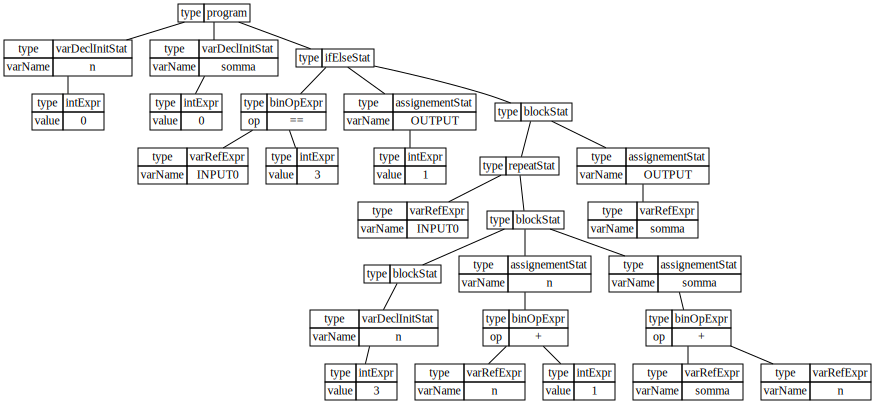

In [51]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
ast

# Decoriamo l'AST con la Symbol Table

Nella *symbol table* memorizziamo per ogni variabile il suo nome "protetto" ossia prefissato da un identificatore unico che dipende dalla tabella stessa.

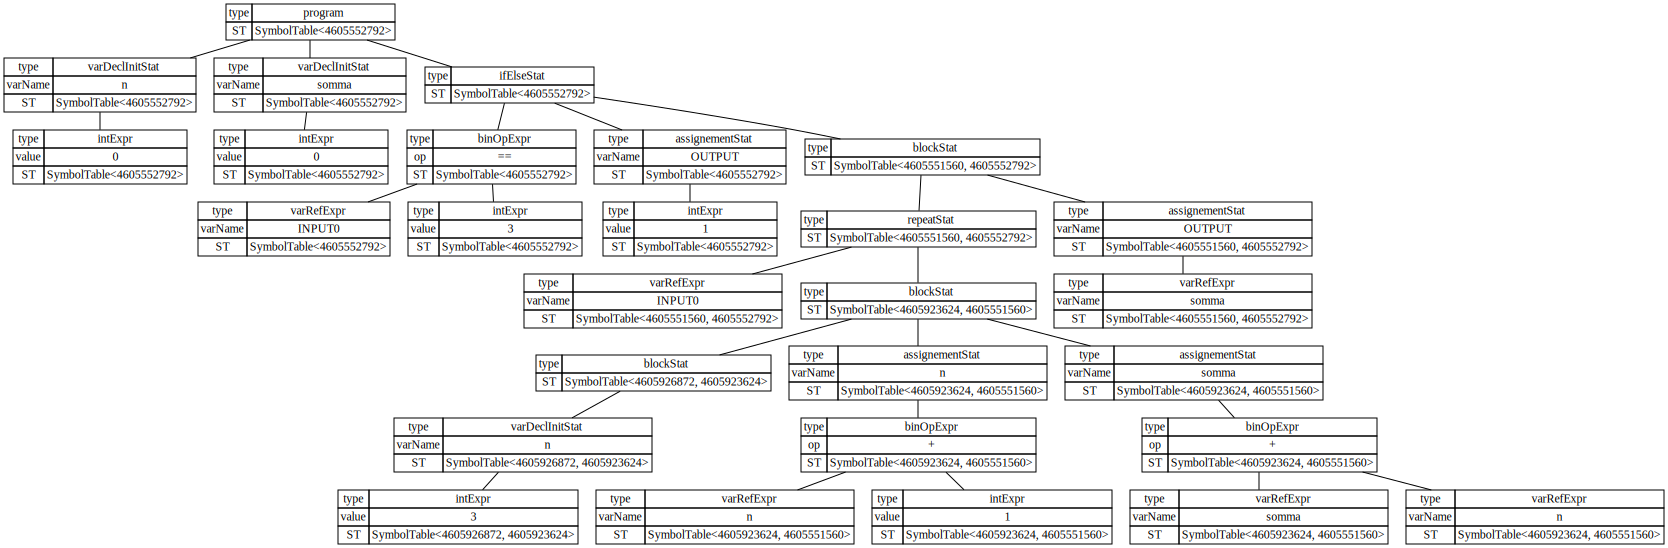

In [52]:
GLOBAL = SymbolTable()
NUM_VARS = 0

def add_name_st(ast, st):
    global NUM_VARS
    
    if ast.root['type'] == 'blockStat': 
        st = SymbolTable(st)
    if ast.root['type'] in {'varDecl', 'varDeclInitStat'}:
        name = 'I_{}'.format(NUM_VARS)
        NUM_VARS += 1
        st.put(ast.root['varName'], name)
    ast.root['ST'] = st
    for child in ast.children: add_name_st(child, st)

add_name_st(ast, GLOBAL)
ast

# Transpilazione verso Python (come stringa)

In [45]:
PYDT = {}

def getName(atree):
    if atree.root['varName'].startswith('INPUT'): return atree.root['varName']
    if atree.root['varName'] == 'OUTPUT': return 'OUTPUT'
    return atree.root['ST'].get(atree.root['varName'])
                                
@register(PYDT)
def intExpr(atree):
    return str(atree.root['value'])

@register(PYDT)
def binOpExpr(atree):
    return '{} {} {}'.format(simple2py(atree.children[0]), atree.root['op'], simple2py(atree.children[1]))

@register(PYDT)
def varRefExpr(atree):
    return getName(atree)

@register(PYDT)
def varDeclStat(atree):
    return '{} = 0'.format(getName(atree))

@register(PYDT)
def varDeclInitStat(atree):
    return '{} = {}'.format(getName(atree), simple2py(atree.children[0]))

@register(PYDT)
def ifStat(atree):
    return 'if {}:\n{}'.format(simple2py(atree.children[0]), indent(simple2py(atree.children[1]), '\t')) 

@register(PYDT)
def ifElseStat(atree):
    return 'if {}:\n{}\nelse:\n{}'.format(simple2py(atree.children[0]), indent(simple2py(atree.children[1]), '\t'), indent(simple2py(atree.children[2]), '\t'))

@register(PYDT)
def repeatStat(atree):
    return 'for rv in range({}): \n{}'.format(simple2py(atree.children[0]), indent(simple2py(atree.children[1]), '\t')) 

@register(PYDT)
def assignementStat(atree):
    return '{} = {}'.format(getName(atree), simple2py(atree.children[0]))

@register(PYDT)
def program(atree):
    return '\n'.join(simple2py(child) for child in atree.children)

@register(PYDT)
def blockStat(atree):
    return '\n'.join(simple2py(child) for child in atree.children)

def simple2py(atree):
    key = atree.root['type']
    if key in PYDT: return PYDT[key](atree)
    return 'UNDEF: ' + '\nUNDEF: '.join(simple2py(child) for child in atree.children)

In [48]:
code = simple2py(ast)
print(code)

I_0 = 0
I_1 = 0
if INPUT0 == 3:
	OUTPUT = 1
else:
	for rv in range(INPUT0): 
		I_0 = 3
		I_0 = I_0 + 1
		I_1 = I_1 + I_0
	OUTPUT = I_1


In [47]:
INPUT0 = 10
exec(code)
print(OUTPUT)

40


In [40]:
INPUT0 = 3
exec(code)
print(OUTPUT)

1


# Controllo (statico) dei tipi (semplici)

Consideriamo una variante del linguaggio in cui ci siano due tipi *semplici*: *interi* e *stringhe* e dove sia consentito solo:

* formare tutte le espressioni binarie con entrambe gli operandi interi,
* confrontare due stringhe, oppure sommare due stringhe (ottenendone la concatenazione), o moltiplicare (in quest'ordine) una stringa per un intero (ottenendone la ripetizione),
* assegnare una espressione di un tipo ad una variabile di quel tipo.

Si assuma inoltre che il risultato di un confronto valga `0` se falso e `-1` se vero.

Potete dare una occhiata a Wikipedia per avere una "infarinatura" delle questioni relative ai [Type System](https://en.wikipedia.org/wiki/Type_system).

In [57]:
SimpleTypedBlockLang = ANTLR(r"""grammar SimpleTypedBlockLang;

program: stat+ ;

block: '{' stat* '}' ;

expr: '!' expr #notExpr
    | expr '*' expr #prodExpr
    | expr ('+'|'-') expr #addSubExpr
    | expr '==' expr #equalityExpr
    | ID #varRefExpr
    | INT #intExpr
    | STRING #strExpr
    | '(' expr ')' #subExpr
    ;

varType: 'int' | 'string' ;

stat: block #blockStat
    | varType ID ('=' expr)? ';' #varDeclStat
    | 'if' expr 'then' stat ('else' stat)? #ifElseStat
    | 'repeat' expr 'times' stat #repeatStat
    | ID '=' expr ';' #assignementStat
    ;

STRING: '"' LETTER* '"' ;
ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

In [58]:
source = r"""
string str = "ciao";
int n = 3;

repeat "pippo" times { n = 0; }

string test;
test = str + str;
test = 3 + str;
test = "ciao" + str;
test = "no" * 2;
n = test == test;
n = n == 3;
n = test == 3;
{
    string n;
    
    test = n * 3;
}
"""

## Costruzione dell'AST

In [59]:
ASTTBDT = {}

@register(ASTTBDT)
def intExpr(ptree):
    return Tree({'type': 'intExpr', 'value': int(ptree.children[0].root['value'])})

@register(ASTTBDT)
def strExpr(ptree):
    return Tree({'type': 'strExpr', 'value': ptree.children[0].root['value'][1:-1]})

@register(ASTTBDT)
def prodExpr(ptree):
    left, _, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': '*'}, [simpleTypedBlock2ast(left), simpleTypedBlock2ast(right)])

@register(ASTTBDT)
def addSubExpr(ptree):
    left, op, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': op.root['name']}, [simpleTypedBlock2ast(left), simpleTypedBlock2ast(right)])
    
@register(ASTTBDT)
def equalityExpr(ptree):
    left, _, right, = ptree.children
    return Tree({'type': 'binOpExpr', 'op': '=='}, [simpleTypedBlock2ast(left), simpleTypedBlock2ast(right)])

@register(ASTTBDT)
def varRefExpr(ptree):
    return Tree({'type': 'varRefExpr', 'varName': ptree.children[0].root['value']})

@register(ASTTBDT)
def varDeclStat(ptree):
    varType = ptree.children[0].children[0].root['name']
    name = ptree.children[1].root['value']
    if len(ptree.children) == 5:
        return Tree({'type': 'varDeclInitStat', 'varName': name, 'varType': varType}, [simpleTypedBlock2ast(ptree.children[3])])
    else:
        return Tree({'type': 'varDeclStat', 'varName': name, 'varType': varType})

@register(ASTTBDT)
def assignementStat(ptree):
    name, _, right, _ = ptree.children
    return Tree({'type': 'assignementStat', 'varName': name.root['value']}, [simpleTypedBlock2ast(right)])

@register(ASTTBDT)
def repeatStat(ptree):
    _, expr, _, block = ptree.children
    return Tree({'type': 'repeatStat'}, [simpleTypedBlock2ast(expr), simpleTypedBlock2ast(block)])

@register(ASTTBDT)
def blockStat(ptree):
    _, *stats, _ = ptree.children[0].children
    return Tree({'type': 'blockStat'}, [simpleTypedBlock2ast(stat) for stat in stats])

@register(ASTTBDT)
def program(ptree):
    return Tree({'type': 'program'}, [simpleTypedBlock2ast(child) for child in ptree.children])

def simpleTypedBlock2ast(ptree):
    key = ptree.root['label'] if ptree.root['type'] == 'rule' else ptree.root['name']
    if key in ASTTBDT: return ASTTBDT[key](ptree)
    return Tree({'type': '<UNDEF>', 'name': ptree.root['name']}, [simpleTypedBlock2ast(child) for child in ptree.children])

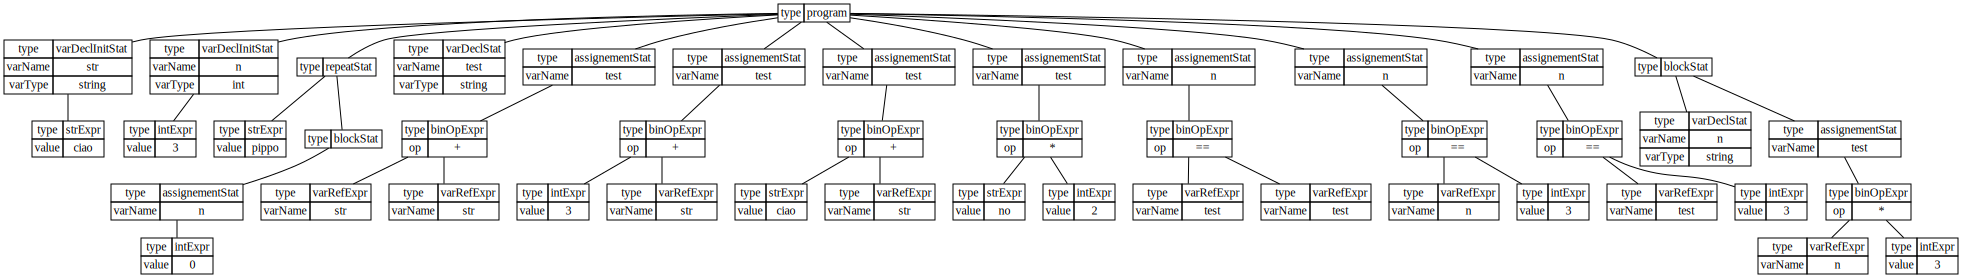

In [61]:
ptree = SimpleTypedBlockLang.tree(source, 'program')
ast = simpleTypedBlock2ast(ptree)
ast

## Decoriamo l'AST con la Symbol Table

Propaghiamo *top-down* il tipo delle variabili dalla loro dichiarazione nel loro *scope*:

In [62]:
def add_type_st(ast, st):
    if ast.root['type'] == 'blockStat': 
        st = SymbolTable(st)
    if ast.root['type'] in {'varDecl', 'varDeclInitStat'}:
        st.put(ast.root['varName'], ast.root['varType'])
    ast.root['ST'] = st
    for child in ast.children: add_type_st(child, st)

In [63]:
ptree = SimpleTypedBlockLang.tree(source, 'program')
GLOBAL = SymbolTable()
add_type_st(ast, GLOBAL)

## Determinazione del tipo delle espressioni

Ora, in modalità *bottom-up* aggiungiamo a nodo corrispondente ad una espressione il suo tipo.

In [64]:
def add_exprType(expr):
    for child in expr.children: add_exprType(child)
    root = expr.root
    nodeType = root['type']
    if nodeType == 'intExpr':
        root['exprType'] = 'int'
    elif nodeType == 'strExpr':
        root['exprType'] = 'string'
    elif nodeType == 'varRefExpr':
        root['exprType'] = expr.root['ST'].get(expr.root['varName'])
    elif nodeType == 'binOpExpr':
        op = expr.root['op']
        left = expr.children[0].root['exprType']
        right = expr.children[1].root['exprType']
        root['exprType'] = None
        if left == 'int' and right == 'int':
            root['exprType'] = 'int'
        else:
            if left == 'string' and right == 'string':
                if op == '+':
                    root['exprType'] = 'string'
                elif op == '==':
                    root['exprType'] = 'int'                    
            if left == 'string' and right == 'int':
                root['exprType'] = 'string'

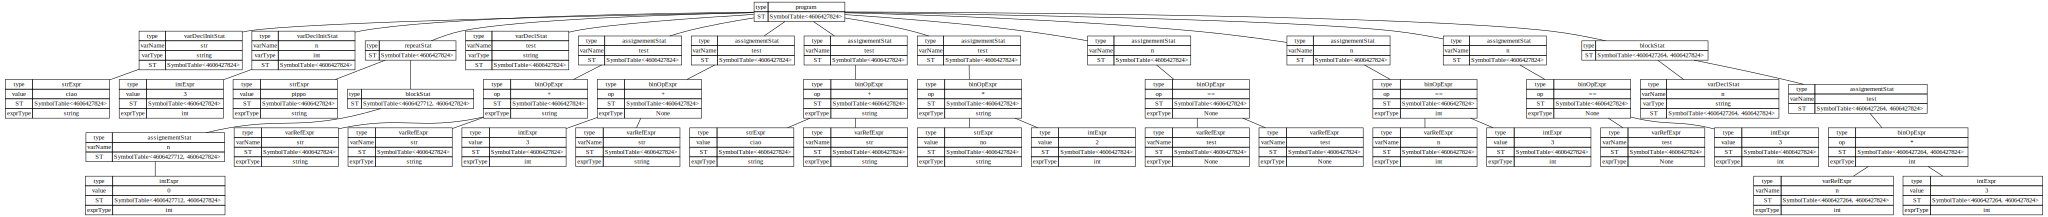

In [65]:
add_exprType(ast)
ast

## Ora controlliamo!

Controlliamo gli *statement*: 

* la selezione e iterazione devono avere un intero come tipo d'espressione,
* gli assegnamenti (anche in dichiarazione) devono concordare con il tipo della variabile,

In [66]:
def check_type(stat):
    for child in stat.children: check_type(child)
    root = stat.root
    nodeType = root['type']
    if nodeType == 'repeatStat':
        if stat.children[0].root['exprType'] != 'integer':
            root['typeCheck'] = 'FAIL'
    elif nodeType == 'varDeclInitStat':
        if stat.children[0].root['exprType'] != root['varType']:
            root['typeCheck'] = 'FAIL'
    elif nodeType == 'assignementStat':
        if stat.children[0].root['exprType'] != root['ST'].get(root['varName']):
            root['typeCheck'] = 'FAIL'    

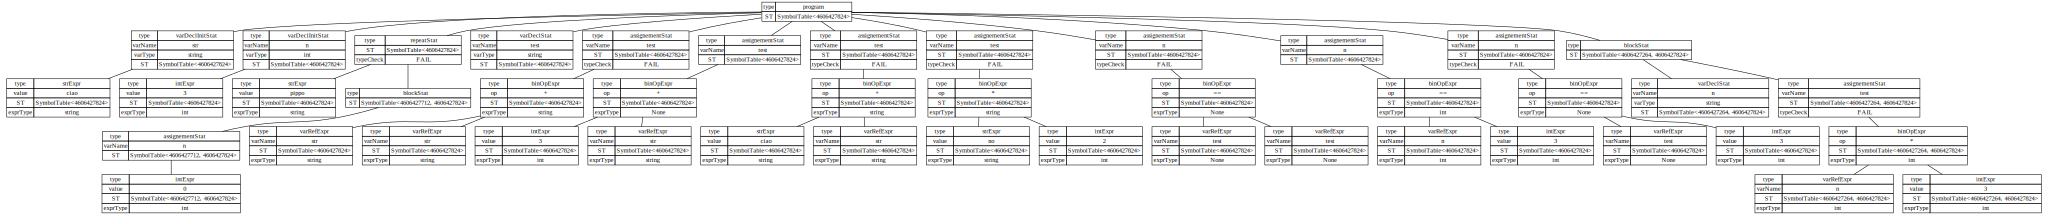

In [67]:
check_type(ast)
ast